In [4]:
## Importing packages
library(tidyverse) # metapackage with lots of helpful functions
library(tidytext)
library(glmnet)
library(randomForest)
library(pROC)
library(gbm)

## Limiting the number of data frame rows displayed
options(repr.matrix.max.rows=8)

## Data attached to this notebook
list.files(path = "../input")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Type 'citation("pROC")' for a citation.


Attaching packa

[1] "bda-2025-sentiment-from-customer-reviews"

<h1 style="background-color:#E3F2FD; color:black; padding:10px; border-radius:8px;">
  BDA: Offensive Tweets Competition
</h1>
<p><strong>Group 5</strong> </p>

# 1. Introduction

The aim of this competition is to classify tweets as offensive (1) or non-offensive (0). Most of the data was obtained from Twitter through keyword-based sampling. The remaining data was either Twitter-based but obtained differently (i.e., multilingual keyword sampling or synthetic data) or from a different source (e.g., Jigsaw toxic comment dataset from Wikipedia). Thus, the combination of sampling strategies defines the population that results obtained here generalise to texts containing explicit offensive content. The raw text data was preprocessed to filter out unnecessary tokens and, thereby, standardise the data (more information [here]('https://www.kaggle.com/competitions/bda-2025-sentiment-from-customer-reviews/data')). The labels were obtained from independent human raters, and the data was class-balanced to ensure approximately equally sized classes.

As the classification is binary, we can only consider ML models that can provide binary predictions. Options include logistic regression, naive Bayes, linear discriminant analysis or quadratic discriminant analysis. Importantly, text classification problems usually involve a lot more features than observations (p >> n). Therefore, it is advisable to either opt for a regularisation method that performs feature selection (e.g., LASSO) or to employ a dimensionality reduction technique (e.g., PCA) before model fitting. Alternatively, one could use tree-based methods, such as bagging, random forests or boosting.

Tree-based methods are another class of models that are well-suited to work with high-dimensional data. For instance, Bagging, Random forests, and Boosting. Tree-based methods often utilise ensemble approaches, where multiple trees are combined to improve predictive accuracy. Ensemble approaches have shown to be particularly effective for classification tasks (Hegelich, 2017). 

Previous research on the topic delivers insights into the performance of different ML methods on similar data. Gaydhani et al. (2018) used Naive Bayes, multinomial regression and support vector machines to classify tweets into three categories (offensive, hateful or clean). The regression model with regularisation performed best with an accuracy of 95.6%. Another study shows that ML classification accuracy is highly dependent on human inter-rater agreement when labelling the data (Leonardelli et al., 2021). The authors compared the performance of the [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) language model in classifying tweets as offensive or not. They found that disagreement among the human annotators about the label negatively affects performance. Overall, these studies show that while it is sensible to aim for a classification accuracy above 90%, high inter-rater disagreement might decrease performance dramatically.

# 2. Importing Data 
The dataset contains 2 separate files: a training set and testing set. We will first build a model on the training data and make predictions for the test data.

In [8]:
dir("../input", recursive=TRUE)

# Find the right file paths
train_filepath = dir("..", pattern="train.csv", recursive=TRUE, full.names = TRUE)
test_filepath = dir("..", pattern="test.csv", recursive=TRUE, full.names = TRUE)

# Read in the csv files
traindat = read_csv(train_filepath, col_types="cci") 
testdat = read_csv(test_filepath, col_types="cc")

glimpse(traindat)
glimpse(testdat)

[1] "bda-2025-sentiment-from-customer-reviews/hate_tweets_test.csv" 
[2] "bda-2025-sentiment-from-customer-reviews/hate_tweets_train.csv"
[3] "bda-2025-sentiment-from-customer-reviews/sample_submission.csv"

Rows: 400,000
Columns: 3
$ id    <chr> "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "…
$ tweet <chr> "not a problem have a nice day", "london at this time of the yea…
$ label <int> 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1…
Rows: 50,001
Columns: 2
$ id    <chr> "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "…
$ tweet <chr> "welcome hello and welcome to wikipedia thank you for i hope you…


The training dataset consists of 400,000 rows, and the test dataset consists of 50,001 rows. 

The training data contains three columms:
1. id: Character id for the tweet
2. tweet: Text of the tweet
3. label: Indicates whether the tweet is offensive (1) or not (0)

The test dataset includes only the id and tweet columns. 

For the predictions, we focus on the tweet column.

# 3. Functions
## 3.1 Feature engineering


Below, we compute document-level features and word-level features. Document-level features describe the characteristics of the tweet as a whole rather than focusing on the words in the tweet itself, while word-level features captures the importance of individual and sequences of words within the tweets without considering word order. 

We compute word-level features using the bag-of-words (BoW) model. The most common features within the BoW model are term frequency (TF), inverse document frequency (IDF), and their product, TF-IDF. TF measures how often a term appears in a tweet, IDF measures how "surprising" a word is across the entire dataset, and the TF-IDF score allows us to quantify the importance of a term in a given document. 

### 3.1.1 Tweet length

We start by computing the length of each tweet, as offensive tweets may differ in length compared to normal tweets.

In [11]:
## Tweet length
get_tweet_lengths <- function(traindat) { 
    tweet_lengths <- traindat |>
        group_by(id) |>
        summarise(length = str_length(tweet)) # Returns numeric vector with the number of characters in each tweet
    return(tweet_lengths)
}

### 3.1.2 Sentiment Analysis

Offensive tweets might have a more negative sentiment. 
For our sentiment analysis, we use the bing lexicon which characterises words as positive or negative, and code words with negative sentiment as -1, and words with positive sentiment with +1. The overall sentiment of each tweet is then calculated by summing the sentiment scores of the words it contains. 

In [12]:
## Sentiment analysis
# Helper functions
get_sentiment_value <- function(word, sentiment_dict) {
  val <- sentiment_dict[sentiment_dict$word == word, ]$sentiment # obtain sentiment score of a word from sentiment dictionary
  if (is_empty(val)) {
    return(NA) # if the word is not found in the sentiment dictionary, NA is returned
  }
  return(val)
}

# Compute sentiments per tweet
sentiment_per_tweet <- function(tweet, sentiment_dict) {
  words <- str_split(tweet, " ", simplify = TRUE)[1, ] # splits tweet by words (space) and returns a character matrix 
  
  res <- sum( # sum sentiment scores of each word in a tweet
    unlist(
      sapply(words, get_sentiment_value, sentiment_dict = sentiment_dict) # Returns vector of sentiment scores for each tweet
    ),
    na.rm = TRUE
  )
  return(res)
}

# Wrapper function for sentiment analysis
compute_sentiments <- function(traindat) {
    # get sentiment dictionary
    sentiment_dict <- tidytext::get_sentiments("bing")
    sentiment_dict$sentiment <- ifelse(sentiment_dict$sentiment == "negative", -1, 1) # Assigning words with negative sentiment to -1, and words with positive sentiment to +1
    
    # obtain overall sentiment for each tweet
    sentiment_vals <- sapply(
        traindat$tweet, 
        sentiment_per_tweet, # Applies function that calculates sentiment of each tweet to all the tweets in the training data
        sentiment_dict = sentiment_dict,
        USE.NAMES = FALSE  
    )
    return(sentiment_vals) # Returns numeric vector of the sentiment score for all the tweets in the training dataset
}

### 3.1.3 Hurtlex

HurtLex (Bassignana et al., 2018) is a lexicon of offensive, aggressive, and hateful words in over 50 languages. In order to assess the amount of offensive words in a single tweet, we add an extra feature, in_hurtlex, that quantifies the percentage of words in each tweet that are present in the Hurtlex lexicon.

In [13]:
## Hurtlex features
url <- "https://raw.githubusercontent.com/valeriobasile/hurtlex/refs/heads/master/lexica/EN/1.2/hurtlex_EN.tsv"
hurtlex <- read_tsv(url) |>
    select(lemma)

# Function to extract Hurtlex feature
compute_hurtlex <- function(traindat) {
    in_hurtlex <- traindat |>
        mutate(hurtlex_n = ifelse(token %in% hurtlex$lemma, 1, 0)) |> # Assign offensive words to +1, and normal words to 0
        group_by(id) |>
        summarize(in_hurtlex = sum(hurtlex_n) / sum(n)) |> # Computes the percentage of offensive words in each tweet
        ungroup() |>
        replace_na(list(in_hurtlex = 0)) |> # Assign 0 to tweets that do not contain words in the Hurtlex lexicon
        arrange(as.numeric(id)) |>
        pull(in_hurtlex)
    return(in_hurtlex)
}

Rows: 8228 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): id, pos, category, stereotype, lemma, level

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## 3.2 Model fitting

We now wrap the whole model fitting procedure into a single function to avoid unnecessary clutter in the notebook. This allows us to experiment with different combinations of features and models efficiently with the use of arguments:
- `dat` refers to the training data set;
- `ngrams` define tokenization based on words (1) or bigrams (2);
- `excludeStop` and `stopWords` control stopword removal;
- `computeFeat` is where we can extract additional features;
    - `tweet_lengths`, `sentiment_vals` and `in_hurtlex` refer to features defined previously;
- `model` refers to the model chosen to fit the data (Lasso, Ridge or Elastic)
- `performanceMeasure` defines the measure to be used in evaluation (default = "auc");

In order to get access to specific tables and matrices calculated within the function, we also added two arguments which help this process:
- `returnXonly` is a logical argument `TRUE/FALSE` that indicates whether to only return the sparse matrix `X`;
- `returnPerformanceOnly` is a logical argument `TRUE/FALSE` that indicates whether to only return the AUC and accuracy of the procedure.

The function always returns 5 objects:
- `model`: the fitted object
- `performance`: data frame with accuracy and AUC
- `features_keep`: features with non-zero variance retained
- `X`: sparse matrix
- `ytrain`: the labels of training data

In [14]:
## Complete function for model fitting and evaluation

fit_model <- function(
    dat, # training data set
    ngrams = 1, # number of words for ngrams; 1 leads to words as tokens
    excludeStop = FALSE, # should stop words be excluded...
    stopWords, # ... if yes, provide list of stopwords here
    computeFeat = FALSE, # should the additional features discussed be extracted
    tweet_lengths, # tweet lengths can be precomputed to increase comp. efficiency
    sentiment_vals, # sentiment values can be precomputed to increase comp. efficiency
    in_hurtlex, # words in Hurtlex can be precomputed to increase comp. efficiency
    model = "lasso", # which model should be fitted?; options include lasso, ridge and elastic
    performanceMeasure = "auc", # which performance measure should be used to find lambda.min
    returnXonly = FALSE, # if TRUE, only the sparse matrix and kept features are returned
    returnPerformanceOnly = FALSE # if TRUE, only df with model performance is returned
 ) {
    
    ## -------------------- TOKENS --------------------
    # Single words
    tokens <- dat |>
        unnest_tokens(token, tweet, token = "words") |> # Splits tweets into single words
        count(token, id) # Counts frequency of each word (unigrams) in each tweet

    # Bigrams
    if (ngrams > 1) {
        bigrams <- dat |>
            unnest_tokens(token, tweet, token = "ngrams", n = ngrams) |> # Splits tweets into sequences of 2 words 
            filter(!is.na(token)) |> 
            count(token, id) # Counts frequency of bigrams in each tweet 

        tokens <- bind_rows(tokens, bigrams) # Combines bigrams to unigrams 
    }

    # Trigrams
    if (ngrams > 2) {
        trigrams <- dat |>
            unnest_tokens(token, tweet, token = "ngrams", n = ngrams) |> # Splits tweets into sequences of 3 words 
            filter(!is.na(token)) |>
            count(token, id) # Counts frequency of trigrams in each tweet

        tokens <- bind_rows(tokens, trigrams) # Combines trigrams to unigrams
    }

    
    ## ------------------- STOPWORDS --------------------
    if (excludeStop) {
        if (missing(stopWords))
            stop("stopWords is missing. Please provide the stop words that you want to exclude.") # Prints this message if stopword vector was not included
        tokens <- tokens |>
            filter(!token %in% stopWords) # Will remove tokens that include the stopwords 
    }


    ## -------------------- TFIDF --------------------
    # compute TFIDF
    tokens <- tokens |>
        bind_tf_idf(token, id, n) # Computes tf, idf, and the product of tf and idf of each token in each tweet 

    # non-zero variance
    tokens <- tokens |> filter(idf <= -log(0.01/100)) # Removes idf with extremely low idf 
        
    # creating feature matrix
    X <- tokens |>
        arrange(as.numeric(id)) |>
        cast_sparse(id, token, tf_idf) # Converts token data into a sparse matrix 

    
    ## --------------- ADDITIONAL FEATURES -----------------
    X_feat <- c() # Combines output into a vector
    if (computeFeat) {
        
        # Sentiment analysis
        if(missing(sentiment_vals))
            sentiment_vals <- compute_sentiments(dat) # If sentiment values are missing in the dataset, it will be computed using the compute_sentiments() function created above
        
        # Tweet length
        if(missing(tweet_lengths))
            tweet_lengths <- get_tweet_lengths(dat)$length # If length of tweet is missing in the dataset, it will be computed using the get_tweet_lengths() function created above
        
        text_features <- dat |>
            mutate(
                url_feat = str_count(tweet, "http") # When someone types out a link, will count how many URLs are in each tweet
            ) |> 
            select(id, url_feat)

        # Hurtlex
        if(missing(in_hurtlex))
            in_hurtlex <- compute_hurtlex(tokens) # If hurtlex percentages are missing in the dataset, it will be computed using the compute_hurtlex() function created above
            
        # reorder rows to match sparse matrix
        idx <- as.numeric(intersect(dat$id, rownames(X)))
        url_feat <- text_features[idx, ]$url_feat 
        sentiment_vals <- sentiment_vals[idx]
        tweet_lengths <- tweet_lengths[idx] 

        X_feat <- cbind(url_feat, sentiment_vals, tweet_lengths, in_hurtlex)
        #print(head(X_feat))
    }

    # Bind additional features to the sparse matrix containing TF-IDF
    X <- cbind(X, X_feat) 

    
    ## --------------- SPARSE MATRIX EXTRACTION ---------------
    if (returnXonly)
        return(list(
            X = X,
            features_keep = tokens
        )) # Will only return the sparse matrix & kept features as the output if set to TRUE


    ## ------------------ TRAIN-TEST SPLIT ------------------
    # obtain labels
    y <- data.frame(id = rownames(X)) |> 
    inner_join(dat, by = "id") |> 
    pull(label) # Creates a data frame with labels extracted

    # train-test split
    trainidx = caret::createDataPartition(y, p = 0.8)$Resample1 # Split 80% of the data into the training set and 20% to the testing set
    
    Xtrain = X[trainidx, ]
    ytrain = y[trainidx] # Data for the training set
    
    Xvalid = X[-trainidx, ]
    yvalid = y[-trainidx] # Data for the testing set

    
    ## --------------------- MODEL FITTING ---------------------
    # glmnet
    fit <- glmnet::cv.glmnet(
        Xtrain, 
        ytrain, # Use training data as input 
        family = "binomial",  # Binary classification (offensive = 1, normal = 0)
        nfolds = 3, # 3 fold cross-validation
        type.measure = "auc",
        alpha = ifelse(model == "lasso", 1, ifelse(model == "ridge", 0, 0.5)) # For lasso model, alpha is set to 1. For the ridge model, alpha is set to 0. For the elastic model, alpha is set to 0.5
    ) 

    ## Model evaluation
    # Accuracy
    pred = predict(fit, Xvalid, s = 'lambda.min', type = 'class') |> factor() # Predicts classes using the training dataset
    acc <- mean(pred == yvalid) |> round(3) # Obtain prediction accuracy rounded to 3 decimal places
    
    # Computing the AUC
    pred_auc <- predict(fit, Xvalid, s = 'lambda.min', type = "response") |> drop() 
    auc <- glmnet::assess.glmnet(pred_auc, newy = yvalid, family = "binomial")$auc |> 
        round(3) # Extract auc of model 

    model_eval <- data.frame(acc, auc) # Creates data frame containing only the accuracy and AUC of fit model

    
    ## --------------- PERFORMANCE EXTRACTION ---------------
    if (returnPerformanceOnly)
        return(model_eval) # If set to TRUE will only return the acc & auc of the model that was fit 

    
    ## ------------------ RETURN OBJECT ------------------
    # returns fitted object, df with acc and auc on validation set,
    # features kept after non-zero variance, sparse matrix (X) and
    # ytrain
    return(list(
        model = fit, 
        performance = model_eval,
        features_keep = tokens,
        X = X,
        ytrain = ytrain
    )) # Returns model, the accuracy & AUC of model, features retained, sparse feature matrix, and the training labels
}

# 4. Model selection procedure

To increase computational efficiency, we adopted a hierarchical approach for selecting the best model. First, determine the best tokenization for classifying the tweets, comparing unigrams, bigrams and trigrams. Note that we only use 1,000 tweets for model selection. This number will be increased for fitting the final model.

## 4.1 Tokenization
The `tidytext` package allows us to tokenize the text into individual components. We can then count how often each token appears per tweet. Tokens are assigned an ID based on its row number to enable us to trace each token to its source tweet. Tokens can take on multiple forms- single words (unigrams), pairs of words (bigrams), and longer sequences known as n-grams. The token type can affect how much context is captured in the text. 

In [21]:
# subset of the data
traindat <- slice_head(traindat, n = 1000)

# plotting function
plot_res <- function(x, measure, x_lab = "n") {
    tibble(cbind(x, measure)) |>
    pivot_longer(c(acc, auc), names_to = "measure", values_to = "value") |> # Create a column for accuracy and AUC for model plotting
    ggplot(aes(x = x, y = value, fill = measure)) +
    geom_col(position = "dodge") +
    coord_flip() + # Create horizontal bars for easy comparison
    labs(x = x_lab) +
    theme_minimal()
} # Creates plot of AUC & accuracy of model for different values of n

n,acc,auc
<int>,<dbl>,<dbl>
1,0.625,0.707
2,0.665,0.691
3,0.665,0.722


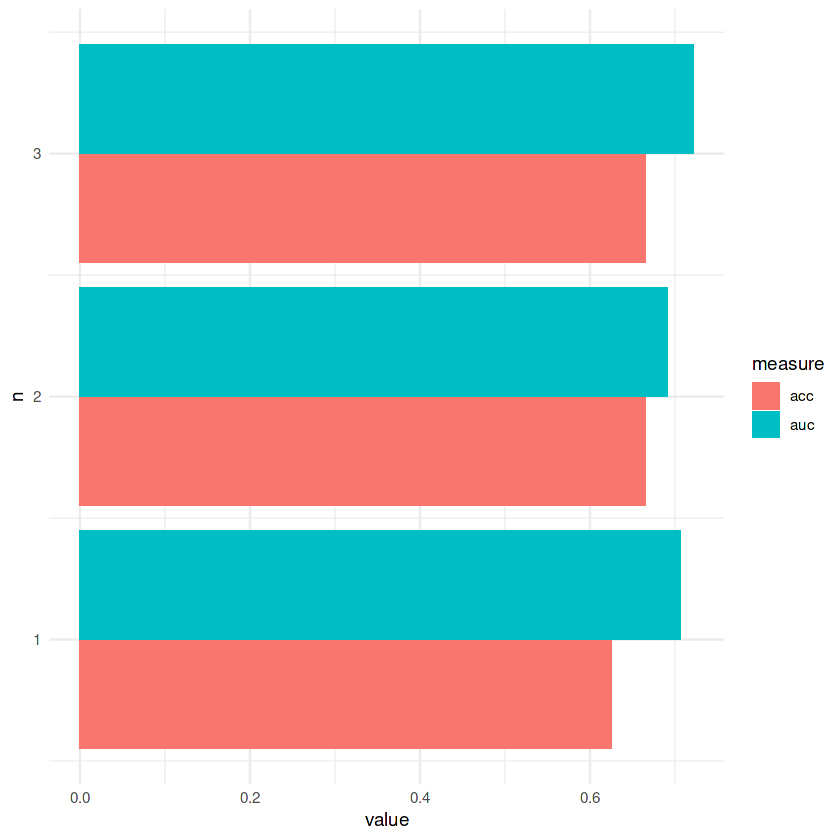

In [22]:
n <- 1:3 # unigram, bigrams, trigrams
out <- map_dfr(n, fit_model, dat = traindat, returnPerformanceOnly = TRUE) # Apply fit_model() function derived above to each value in n
plot_res(n, out) # Plot accuracy and AUC of unigrams, bigrams and trigrams
cbind(n, out) # table for comparison

The models show similar performance. For computational simplicity, we proceed with the model that only includes unigrams for now.

## 4.2 Stop words

Stopwords are words that carry little information, for instance, words such as "a", "the", and "are" occur very frequently in any text, and do not vary a lot across different contexts. However, in the context of detecting offensive tweets, some commonly used words such as “you” may carry lots of information. 

To account for this, we extract stopwords using the SMART, onix and snowball lexicons and compare model performance to determine which stopword lexicon performs is best suited for detecting offensive tweets.

In [23]:
# words as tokens
tokens <- traindat |>
    unnest_tokens(token, tweet, token = "words") |>
    count(token, id) 

In [24]:
# Isolate stop word lexicons
smart <- stop_words |> filter(lexicon == 'SMART') |> distinct(word)
onix <- stop_words |> filter(lexicon == 'onix') |> distinct(word)
snow <- stop_words |> filter(lexicon == 'snowball') |> distinct(word)

# Separate dataset with and without stop words
tokens_smart <- tokens |> anti_join(smart, by = join_by(token == word))
tokens_onix <- tokens |> anti_join(onix, by = join_by(token == word))
tokens_snow <- tokens |> anti_join(snow, by = join_by(token == word))

# Compute token features
features   <- tokens |> bind_tf_idf(token, id, n)
feat_smart <- tokens_smart |> bind_tf_idf(token, id, n)
feat_onix <- tokens_onix |> bind_tf_idf(token, id, n)
feat_snow <- tokens_snow |> bind_tf_idf(token, id, n)

# Removing features with near-zero variance features
features_keep <- features |> filter(idf <= -log(0.01/100))
feat_smart_keep <- feat_smart |> filter(idf <= -log(0.01/100))
feat_onix_keep <- feat_onix |> filter(idf <= -log(0.01/100))
feat_snow_keep <- feat_snow |> filter(idf <= -log(0.01/100))

# Gather all features groups
feat_list <- list(keep  = features_keep,
                  smart = feat_smart_keep,
                  onix  = feat_onix_keep,
                  snow  = feat_snow_keep)

In order to determine which stopword removal lexicon produces the best model performance, we create a function that will pass them through a full analysis pipeline and compare the results.

In [25]:
## Function for full analysis comparison between all stopword lexicons

# tibble to store results
comp <- tibble(model    = c(),
               stopword = c(),
               lambda   = c(),
               accuracy = c(),
               auc      = c(),)

# Loop
fitModels <- function(feat, stopword) {

    # ---------- Prepare features for glmnet ----------
    
    # Convert features to a sparse matrix
    X <- feat |> cast_sparse(id, token, tf_idf)
    
    # Target variable
    y <- data.frame(id=rownames(X)) |> inner_join(traindat, by="id") |> pull(label)


    # ---------- Train and Validation split ----------
    set.seed(2025)
    trainidx = caret::createDataPartition(y, p=0.8)$Resample1
    
    Xtrain = X[trainidx,]
    ytrain = y[trainidx]
    
    Xvalid = X[-trainidx,]
    yvalid = y[-trainidx]


    # -------------------- Fit models --------------------
    
    ## Lasso
    fit_lasso <- glmnet::cv.glmnet(Xtrain, ytrain, family="binomial",  nfolds=3, type.measure="auc")
    lambda_lasso <- fit_lasso$lambda.min |> round(3) # Extract lambda.min rounded to 3 decimal places
    
    ## Ridge
    fit_ridge <- glmnet::cv.glmnet(Xtrain, ytrain, alpha = 0, family="binomial", nfolds=3, type.measure="auc")
    lambda_ridge <- fit_ridge$lambda.min |> round(3)

    
    # -------------------- Evaluation --------------------
    
    ## Lasso
    # Accuracy
    pred_lasso = predict(fit_lasso, X, s='lambda.min', type='class') |> factor()
    acc_lasso <- mean(pred_lasso == y) |> round(3) # Computes accuracy of lasso model rounded to 3 decimal places
    
    # Computing the AUC
    pred_lasso <- predict(fit_lasso, Xvalid, type= "resp") |> drop()
    auc_lasso <- glmnet::assess.glmnet(pred_lasso, newy=yvalid, family="binomial")$auc |> round(3) # Computes AUC of lasso model rounded to 3 decimal places

    ## Ridge
    # Accuracy
    pred_ridge = predict(fit_ridge, X, s='lambda.min', type='class') |> factor()
    acc_ridge <- mean(pred_ridge == y) |> round(3) # Computes accuracy of ridge model rounded to 3 decimal places
    
    # Computing the AUC
    pred_ridge <- predict(fit_ridge, Xvalid, type= "resp") |> drop()
    auc_ridge <- glmnet::assess.glmnet(pred_ridge, newy=yvalid, family="binomial")$auc |> round(3) # Computes AUC of ridge model rounded to 3 decimal places


    # -------------------- Store results --------------------
    
    tibble(model    = c("Lasso", "Ridge"),
           stopword = rep(stopword, 2),
           lambda   = c(lambda_lasso, lambda_ridge),
           accuracy = c(acc_lasso, acc_ridge),
           auc      = c(auc_lasso, auc_ridge))

} 


# Apply function to datasets
comp <- map2_dfr(
  feat_list,            # each feature tibble
  names(feat_list),     # the stopword lexicon name
  ~ fitModels(.x, .y)   # apply fitModels(feat, stopword)
)

[1] "Best Accuracy: Ridge (keep) = 0.938"

[1] "Best AUC: Lasso (keep) = 0.725"

model,stopword,lambda,accuracy,auc
<fct>,<chr>,<dbl>,<dbl>,<dbl>
Lasso,keep,0.025,0.785,0.725
Ridge,keep,0.933,0.938,0.713
Lasso,smart,0.023,0.798,0.708
Ridge,smart,0.923,0.934,0.707
Lasso,onix,0.018,0.854,0.712
Ridge,onix,0.955,0.923,0.670
Lasso,snow,0.023,0.803,0.673
Ridge,snow,0.812,0.931,0.708


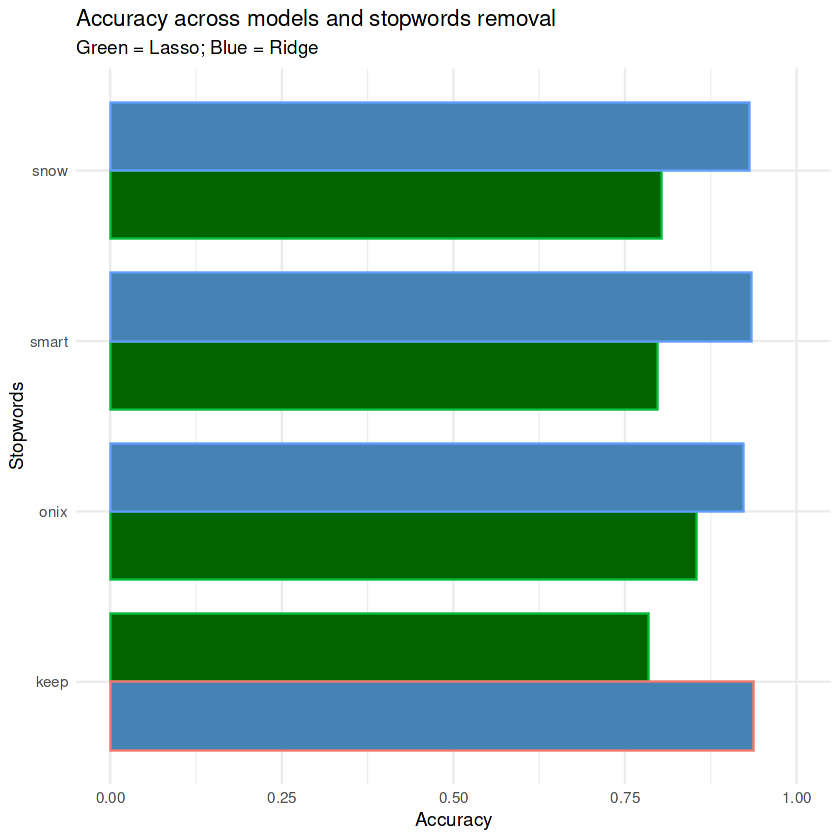

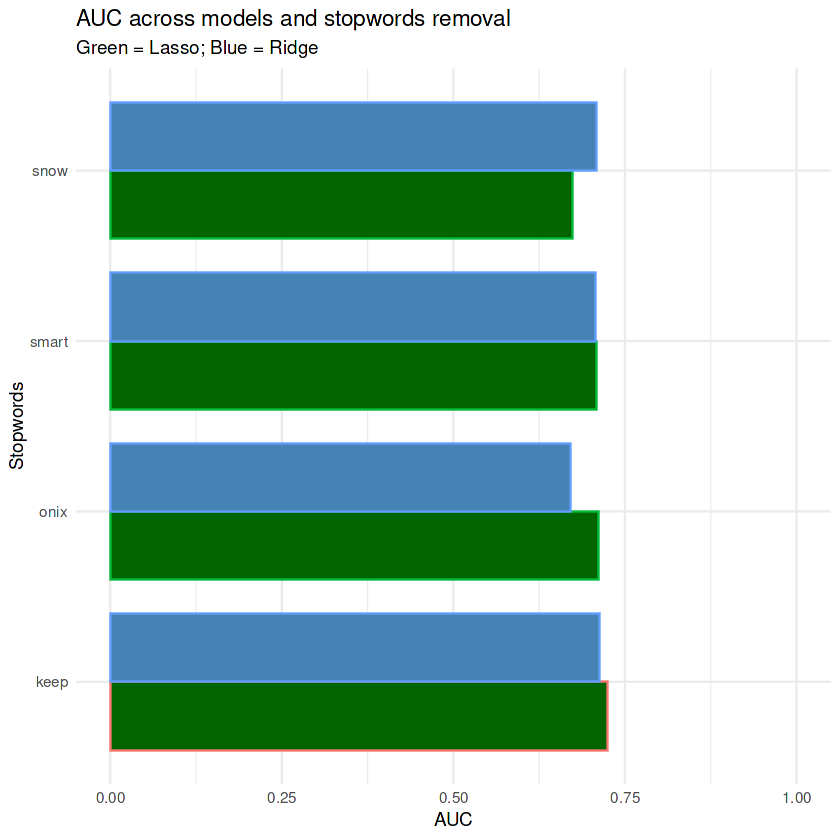

In [26]:
## Model comparisons

# Keep models in order
comp <- comp |>
  mutate(
    model = factor(model, levels = c("Lasso", "Ridge"))
  ) # Lasso appears first, and then ridge

# Best models
best_acc <- comp |> filter(accuracy==max(accuracy)) |> select(model, stopword, accuracy)
best_auc <- comp |> filter(auc==max(auc)) |> select(model, stopword, auc) # Find model and stopword lexicon with the highest accuracy & AUC

paste0("Best Accuracy: ", best_acc$model, " (", best_acc$stopword, ") = ", best_acc$accuracy)
paste0("Best AUC: ", best_auc$model, " (", best_auc$stopword, ") = ", best_auc$auc) # Summary of the best performing model's accuracy & AUC

# Table of comparison
comp

# Accuracy plot
comp |> # compares all stopword lexicons fitted using lasso and ridge regression
    ggplot(aes(x = accuracy, y = stopword, fill = model)) + # Creates horizontal barplots by matching y to stopword and x to accuracy
    geom_col(
        aes(color = ifelse(accuracy >= max(accuracy, na.rm = TRUE), "Best", as.character(model))), 
        position = position_dodge(width = 0.8),
        width = 0.8,
        show.legend = FALSE
    ) +
    scale_fill_manual(
        values = c("Best" = "orange", "Lasso" = "darkgreen", "Ridge" = "steelblue") # Model with the highest accuracy is highlighted in orange
    ) +
    coord_cartesian(xlim = c(0,1)) +
    labs(
        title = "Accuracy across models and stopwords removal",
        subtitle = "Green = Lasso; Blue = Ridge",
        x = "Accuracy",
        y = "Stopwords"
    ) +
    theme_minimal()


# AUC plot
comp |> 
    ggplot(aes(x = auc, y = stopword, fill = model)) +
    geom_col(
        aes(color = ifelse(auc >= max(auc, na.rm = TRUE), "Best", as.character(model))), 
        position = position_dodge(width = 0.8),
        width = 0.8,
        show.legend = FALSE
    ) +
    scale_fill_manual(
        values = c("Best" = "orange", "Lasso" = "darkgreen", "Ridge" = "steelblue") # Model with the highest AUC is highlighted in orange
    ) +
    coord_cartesian(xlim = c(0,1)) +
    labs(
        title = "AUC across models and stopwords removal",
        subtitle = "Green = Lasso; Blue = Ridge",
        x = "AUC",
        y = "Stopwords",
    ) +
    theme_minimal()

Based on this analysis, we conclude that **Lasso** seems to be better in terms of AUC compared to ridge, so we choose Lasso. There do not seem to be major benefits of removing stopwords, so we choose to retain them in case they carry important information in the remaining training and test set.

## 4.3 Feature selection

"c(TRUE, FALSE)",acc,auc
<lgl>,<dbl>,<dbl>
TRUE,0.69,0.715
FALSE,0.62,0.678


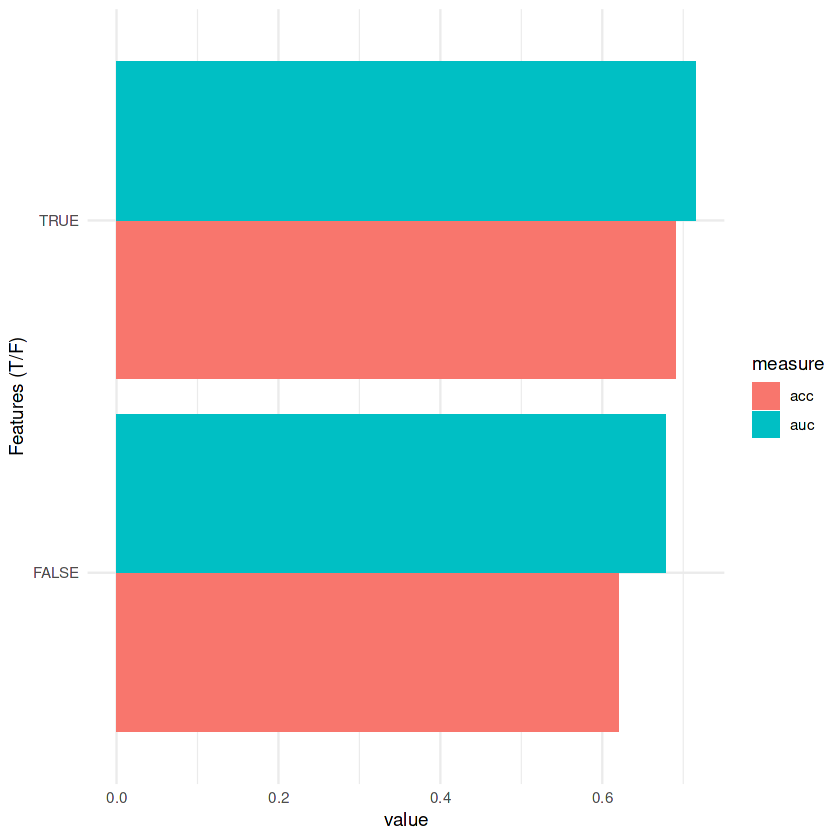

In [27]:
# pre-compute some features to apply function more efficiently
sentiment_vals <- compute_sentiments(traindat)
tweet_lengths <- get_tweet_lengths(traindat)$length # Calculate sentiment scores and tweet lengths 
out <- map_dfr(
    c(TRUE, FALSE), # Fit 2 models using the fit_model() function defined above using computeFeat = TRUE/FALSE
    fit_model,
    dat = traindat, 
    ngrams = 1, 
    excludeStop = FALSE, 
    stopWords = NULL,
    tweet_lengths = tweet_lengths,
    sentiment_vals = sentiment_vals,
    model = "lasso", 
    performanceMeasure = "auc", 
    returnXonly = FALSE, 
    returnPerformanceOnly = TRUE
)
cbind(c(TRUE, FALSE), out) # show performances
plot_res(c(TRUE, FALSE), out, x_lab = "Features (T/F)")

Based on the accuracy and AUC results, the model with additional features performs better than the model without them. Therefore, we choose to retain the additional features for the final model. 
## 4.4 Tree-based methods

Tree based methods use decision trees to model relationships between predictors and the outcome, and these methods can be applied to regression and classification problems. In this section, we fit a random forest and boosting model to the data to compare model performance.

### Random forest

Random forest uses an ensemble method where it combines simple building block models to obtain a single powerful model. The final prediction is made by taking a majority vote across all trees. We now fit a random forest to the training data to see if this model will improve prediction accuracy. 

In [9]:
traindat = read_csv(train_filepath, col_types="cci") |> slice_head(n = 1000)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Random Forest AUC: 0.737067230273752"

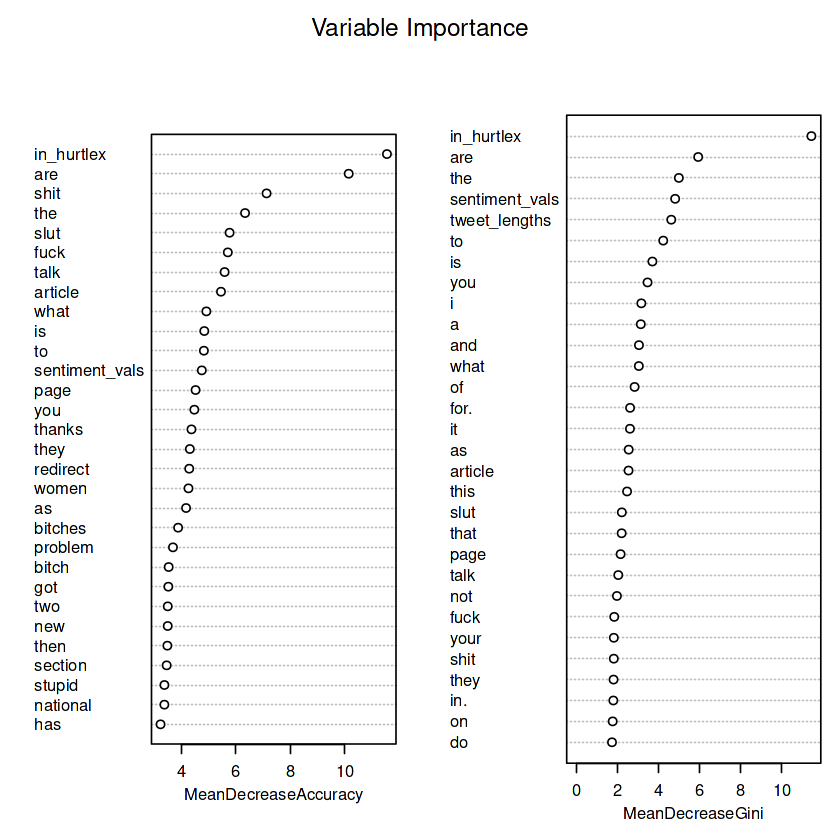

In [15]:
## Random Forest
# Get sparse matrix
X <- fit_model(traindat, computeFeat = TRUE, returnXonly = TRUE)$X

# obtain labels
y <- data.frame(id = rownames(X)) |> 
    inner_join(traindat, by = "id") |> 
    pull(label) 

# train-test split
trainidx = caret::createDataPartition(y, p = 0.8)$Resample1

Xtrain = X[trainidx, ]
ytrain = y[trainidx]

Xvalid = X[-trainidx, ]
yvalid = y[-trainidx]


# Convert ssparse matrices to dense data frames as random forests cannot work with sparse matrices 
ytrain_factor <- factor(ytrain)
yvalid_factor <- factor(yvalid)

Xtrain_df     <- as.data.frame(as.matrix(Xtrain))
Xvalid_df     <- as.data.frame(as.matrix(Xvalid))


# Sanitize variable names
names(Xtrain_df) <- make.names(names(Xtrain_df))
names(Xvalid_df) <- make.names(names(Xvalid_df))

# Add labels
Xtrain_df$y   <- ytrain_factor

# Fit model
set.seed(2307)
fit_rf <- randomForest(y ~ .,
                       data = Xtrain_df,
                       probability = TRUE,
                       importance = TRUE,
                       ntree = 300)


# Predict
pred <- predict(fit_rf, newdata = Xvalid_df, type = "prob")[,2] |> unname()

# Compute AUC
auc <- auc(yvalid, pred)
paste0("Random Forest AUC: ", auc)

# Checking importance 
varImpPlot(fit_rf,
            main = "Variable Importance",
            cex = 0.8)

### Boosting
Boosting also uses an ensemble method, but decision trees are built sequentially, where each new tree aims to correct the errors made by the previous trees. We fit a boosting model to the training data to evaluate model performance.

In [16]:
## Boosting
# create a tuning parameter grid to try out different combinations
params <- expand.grid(
  shrink = c(0.001, 0.05, 0.1, 0.2),
  inter_depth = c(1, 2, 4, 8)
)

# gbm function needs outcome to be coded as 0s and 1s
Xtrain_df$y <- ifelse(Xtrain_df$y == 1, 0, 1)

For boosting, we need to make a few decisions. We need to determine values for the shrinking and interaction.depth tuning parameters. Furthermore, we need to select a value for the number of trees. We will loop over a grid of tuning parameters, but let's first look at a plot that gives us an idea about the number trees we should consider. To achieve this, we fit the model to the training data using CV and track the CV error across the number of trees.

Note: In the following code blocks, we suppress warnings from fitting the model. The `gbm` function returns warnings if some features have 0 variance. Since this is quite common when splitting the sparse matrix into a train and validation set, (if you exclude some the only tweets that include a word from the training set, the remaining values for the feature are all 0) we decided to suppress these messages to avoid unnecessary clutter in the notebook.

In [17]:
# Fit the model to the training set
fit_gbm <- suppressWarnings(
        gbm(
            y ~., 
            distribution = "bernoulli",
            data = Xtrain_df, 
            n.trees = 300,
            cv.fold = 5
        ) 
    )

# finding the optimal tree-depth based on CV performance 
# this also creates the desired plot
opt_depth <- gbm.perf(fit_gbm, method = "cv", plot.it = TRUE)
opt_depth

The plot shows that the test error shown in green already starts increasing at a low number of trees, so specifying `n.trees = 200` should be more than enough when searching for the optimal set of tuning parameters.

In [18]:
# This function applies boosting for a combination of tuning parameters
# and returns the AUC
auc_boost <- function(formula, traindat, testdat, params) {
    fit <- suppressWarnings(
        gbm(
            formula, 
            distribution = "bernoulli",
            data = traindat, 
            n.trees = 200,
            shrinkage = params["shrink"],
            interaction.depth = params["inter_depth"]
        ) 
    )
    
    # finding the optimal number of trees based on out-of-bag (OOB) performance 
    # using OOB instead of CV prevents having to run the fitting procedure
    # multiple times
    opt_depth <- gbm.perf(fit, method = "OOB", plot.it = FALSE)

    # prediction based on optimal number of trees
    pred <- predict(
        fit,
        newdata = testdat,
        type = "response",
        n.trees = opt_depth
    )

    # compute auc and return with corresponding parameters
    auc <- auc(yvalid, pred)
    out <- data.frame(
        shrinkage = params["shrink"], 
        inter_depth = params["inter_depth"], 
        auc
    )
    
    return(out) 
}

# apply the function to the parameter grid
res <- apply(
    params, 
    1, 
    auc_boost,
    formula = y ~ .,
    traindat = Xtrain_df, 
    testdat = Xvalid_df,
    simplify = FALSE
)

# bind list entries into df
res_df <- do.call(rbind.data.frame, res)
rownames(res_df) <- NULL # remove rownames

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.

Setting levels: control = 0, case = 1

Setting direction: controls > cases

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.

Setting levels: control = 0, case = 1

Setting direction: controls > cases

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.

Setting levels: control = 0, case = 1

Setting direction: controls > cases

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calli

,shrinkage,inter_depth,auc
,<dbl>,<dbl>,<dbl>
1,0.05,2,0.7297202


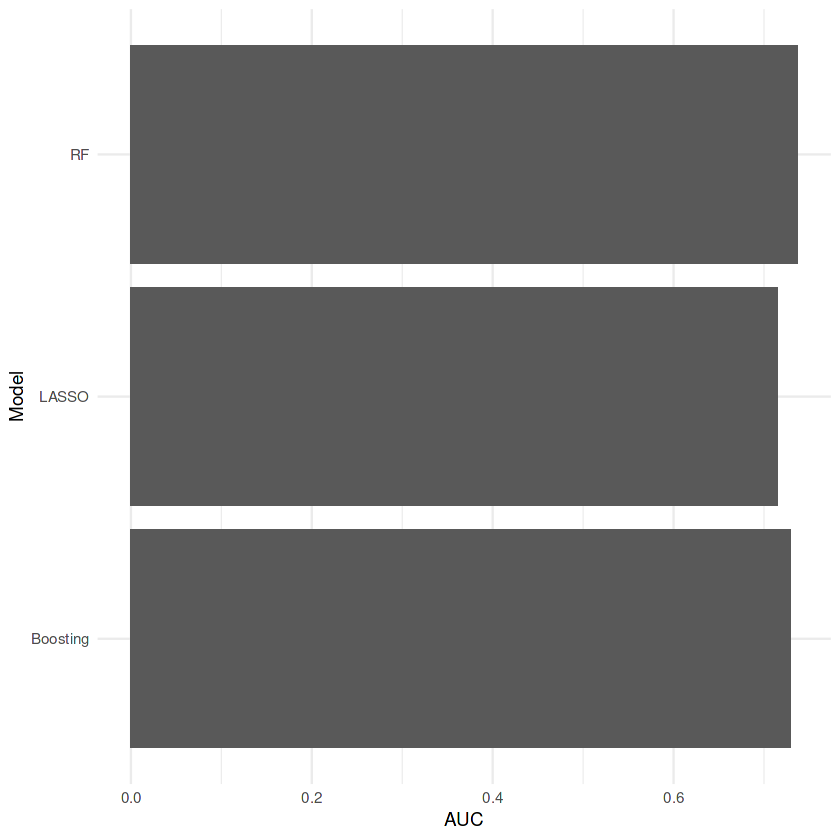

In [28]:
# sort by auc and look at best combination
arrange(res_df, desc(auc))[1, ]

# Plotting the AUCs for all models
tibble(
    AUC = c(max(out$auc), auc, max(res_df$auc)),
    Model = c("LASSO", "RF", "Boosting")
) |>
    ggplot(aes(x = Model, y = AUC)) +
    geom_col() +
    coord_flip() +
    theme_minimal()

# 5. Conclusion

The goal of our analysis was to predict offensive tweets. To achieve this, we first computed document-level and word-level features, evaluated different stopword lexicons to determine which would maximise model performance, and tokenised the tweets into unigrams, bigrams and trigrams. We then tested multiple combinations of document-level and word-level features to evaluate model performance and found that including all along with produced the highest AUC.

Finally, we fit several models, including Lasso regression, Ridge regression, Random Forests, and Boosting. As shown in the plot above, the tree-based methods tend to be better than logistic regression. Therefore, we wanted to choose one of them for the final submission. However, the packages we used cannot handle sparse matrices, and converting the sparse matrix into a dataframe overflows memory for a reasonably sized training set.

We tried out different tokenizations for the submission. Unigrams and bigrams combined seemed to perform best, so we chose these to be included in our final Lasso logistic regression.


# 6. Submitting Prediction

In [ ]:
# increase training data for final model
traindat = read_csv(train_filepath, col_types="cci")

# final model with uni- and bigrams
train_out <- fit_model(
    traindat,
    ngrams = 2,
    computeFeat = TRUE
)

# apply to test data
test_out <- fit_model(testdat, ngrams = 2, computeFeat = TRUE, returnXonly = TRUE)

Below, we prepare the sparse test matrix by converting it into the appropriate format required for model evaluation. This ensures the test data matches the structure of the training data to enable prediction.

In [ ]:
# Keep the unique set of tokens and their idf weights from training
trained_features = train_out[["features_keep"]] |> select(token, idf) |> unique()

# Tokenize test tweets and compute tf–idf values
# (for development: only the first 15,000 tweets; 
#  for final submission: use the entire test set)
test_features <- test_out[["features_keep"]] 
# Force Xtest to have all training columns:
# For a single tweet (id == "1"), insert rows for any training tokens that are missing,
# filling them with zeros. Using only one tweet keeps the dataset sparse and efficient.
test_features_tweet_1 <- test_features |> filter(id == "1") |>
  tidyr::complete(id, token = trained_features$token, fill = list(n = 0, tf=0, idf=0, tf_idf=0)) 

# Replace the original tweet 1 with the completed version
test_features <- bind_rows(
  test_features_tweet_1, 
  test_features |> filter(id !="1")
)

# Join with training idf values, recompute tf–idf (tf * idf from training),
# and convert to a sparse document–term matrix
Xtest <- test_features |> 
  inner_join(trained_features, by='token')  |>
  mutate(tf_idf_y = tf * idf.y) |>
  arrange(as.numeric(id)) |> 
  cast_sparse(id, token, tf_idf_y) 

# compute additional features for test data
X_test_raw <- test_out[["X"]]
ids <- intersect(rownames(X_test_raw), rownames(Xtest))
X_test_feat <- X_test_raw[ids, (ncol(X_test_raw) - 3):ncol(X_test_raw)]
Xtest <- cbind(Xtest, X_test_feat)

# Reorder columns to match Xtrain exactly
colnames_Xtrain <- colnames(train_out[["X"]])
ids <- colnames_Xtrain[colnames_Xtrain %in% colnames(Xtest)]
Xtest <- Xtest[, ids]

# Inspect a slice and check dimensions
Xtest[1:8,20:25]
cat("\ndim(Xtest) = ", dim(Xtest), "\n")

Now, we obtain the predicted probabilities that each tweet contains offensive language.

In [ ]:
pred_test = predict(train_out[["model"]], newx=Xtest, type="resp")
str(pred_test)

We now generate the submission file. For tweets without a predicted probability, a probability that an arbitrary tweet has offensive content is filled in. 

In [ ]:
tibble(id = rownames(pred_test), prob = pred_test[,1]) |>
    right_join(testdat, by="id") |>
    arrange(as.numeric(id)) |> 
    replace_na(list(prob = mean(train_out[["ytrain"]]))) |>
    select(-tweet) |>
    write_csv("submission.csv")

read_csv("submission.csv", col_types="cd") # should be 50,001 x 2

# References

Bassignana, E., Basile, V., & Patti, V. (2018). Hurtlex: a multilingual lexicon of words to hurt. In Accademia University Press eBooks (pp. 51–56). https://doi.org/10.4000/books.aaccademia.3085

Gaydhani, A., Doma, V., Kendre, S., & Bhagwat, L. (2018). Detecting Hate Speech and Offensive Language on Twitter using Machine Learning: An N-gram and TFIDF based Approach (No. arXiv:1809.08651). arXiv. https://doi.org/10.48550/arXiv.1809.08651

Hegelich, S. (2017). Decision Trees and Random Forests: Machine Learning Techniques to Classify Rare Events. _European Policy Analysis_, 98-120, 2(1). https://doi.org/10.18278/epa.2.1.7

Leonardelli, E., Menini, S., Aprosio, A. P., Guerini, M., & Tonelli, S. (2021). Agreeing to Disagree: Annotating Offensive Language Datasets with Annotators’ Disagreement. _Proceedings of the 2021 Conference on Empirical Methods in Natural Language Processing_, 10528–10539. https://doi.org/10.18653/v1/2021.emnlp-main.822